# Demonstrate the GODEEEP Project's Approach to Projecting Load, Wind, and Solar Time Series Under Climate Change


In [1]:
# Start by importing the packages we need:
import os
import glob
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import timedelta


## Set the Directory Structure

In [2]:
# Identify the data input and image output directories:
data_input_dir =  '/Users/burl878/Documents/Code/code_repos/wecc_proof_of_concept/data/'
image_output_dir =  '/Users/burl878/Documents/Code/code_repos/wecc_proof_of_concept/plots/'


## Create a Function to Aggregate the Raw TELL MLP Output:


In [3]:
def aggregate_mlp_output_files(data_input_dir: str, year_to_process: str):
    
    # Create a list of all of the MLP output files in the "mlp_input_dir" and aggregate the files in that list:
    list_of_files = sorted(glob.glob(os.path.join(data_input_dir, 'TELL_Data', year_to_process, '*_mlp_output.csv')))

    # Loop over the list of MLP output files:
    for file in range(len(list_of_files)):

        # Read in the .csv file and replace missing values with nan:
        mlp_data = pd.read_csv(list_of_files[file]).replace(-9999, np.nan)

        # Rename the "Load" variable:
        mlp_data.rename(columns={'Load': 'Hourly_Load_MWh'}, inplace=True)

        # Replacing missing or negative loads with NaN:
        mlp_data.loc[~(mlp_data['Hourly_Load_MWh'] > 0), 'Hourly_Load_MWh'] = np.nan

        # Aggregate the output into a new dataframe:
        if file == 0:
            tell_df = mlp_data
        else:
            tell_df = pd.concat([tell_df, mlp_data])
    
    # Return the output dataframe:
    return tell_df


## Aggregate the Sample Data into a Single Dataframe


In [4]:
# Define a function to process aggregate the sample load, wind, and solar data into a single dataframe:
def aggregate_data(data_input_dir: str):
    # Aggregate the TELL MLP files for 2018:
    tell_2018_df = aggregate_mlp_output_files(data_input_dir = data_input_dir,
                                              year_to_process = '2018')
    
    # Convert the timestamp into a datetime variable:
    tell_2018_df['Datetime'] = pd.to_datetime(tell_2018_df['Time_UTC'])
   
    # Use datetime string to get the year, month, day, and hour:
    tell_2018_df['Year'] = tell_2018_df['Datetime'].dt.strftime('%Y').astype(int)
    tell_2018_df['Month'] = tell_2018_df['Datetime'].dt.strftime('%m').astype(int)
    tell_2018_df['Day'] = tell_2018_df['Datetime'].dt.strftime('%d').astype(int)
    tell_2018_df['Hour'] = tell_2018_df['Datetime'].dt.strftime('%H').astype(int)
    
    # Rename the load variable:
    tell_2018_df.rename(columns={'Hourly_Load_MWh': 'Load_2018_MWh'}, inplace=True)
    
    # Only keep the columns that are needed:
    merged_df = tell_2018_df[['Time_UTC', 'BA', 'Month', 'Day', 'Hour', 'Load_2018_MWh']].copy()
    
    # Aggregate the TELL MLP files for 2058:
    tell_2058_df = aggregate_mlp_output_files(data_input_dir = data_input_dir,
                                              year_to_process = '2058')
    
    # Convert the timestamp into a datetime variable:
    tell_2058_df['Datetime'] = pd.to_datetime(tell_2058_df['Time_UTC'])
   
    # Use datetime string to get the year, month, day, and hour:
    tell_2058_df['Year'] = tell_2058_df['Datetime'].dt.strftime('%Y').astype(int)
    tell_2058_df['Month'] = tell_2058_df['Datetime'].dt.strftime('%m').astype(int)
    tell_2058_df['Day'] = tell_2058_df['Datetime'].dt.strftime('%d').astype(int)
    tell_2058_df['Hour'] = tell_2058_df['Datetime'].dt.strftime('%H').astype(int)
    
    # Rename the load variable:
    tell_2058_df.rename(columns={'Hourly_Load_MWh': 'Load_2058_MWh'}, inplace=True)
    
    # Only keep the columns that are needed:
    tell_2058_df = tell_2058_df[['BA', 'Month', 'Day', 'Hour', 'Load_2058_MWh']].copy()
    
    # Merge the two load dataframes together:
    merged_df = pd.merge(merged_df, tell_2058_df, on=['BA', 'Month', 'Day', 'Hour'])
    
    # Compute the load difference and load ratios:
    merged_df['Load_Difference_MWh'] = merged_df['Load_2058_MWh'] - merged_df['Load_2018_MWh']
    merged_df['Load_Ratio'] = merged_df['Load_2058_MWh'] / merged_df['Load_2018_MWh']
    
    # Read in the wind and solare .csv file:
    renew_df = pd.read_csv((data_input_dir + 'Wind_and_Solar_Data/ba-wind-solar-cf-2018-2058.csv'))
    
    # Rename the variables:
    renew_df.rename(columns={'month': 'Month',
                             'day': 'Day',
                             'hour': 'Hour',
                             'ba': 'BA',
                             'solar_cf_2018': 'Solar_2018_CF',
                             'solar_cf_2058': 'Solar_2058_CF',
                             'wind_cf_2018': 'Wind_2018_CF',
                             'wind_cf_2058': 'Wind_2058_CF'}, inplace=True)
    
    # Compute the wind and solar difference and ratios:
    renew_df['Solar_CF_Difference'] = renew_df['Solar_2058_CF'] - renew_df['Solar_2018_CF']
    renew_df['Solar_CF_Ratio'] = renew_df['Solar_2058_CF'] / renew_df['Solar_2018_CF']
    renew_df['Wind_CF_Difference'] = renew_df['Wind_2058_CF'] - renew_df['Wind_2018_CF']
    renew_df['Wind_CF_Ratio'] = renew_df['Wind_2058_CF'] / renew_df['Wind_2018_CF']
    
    # Only keep the columns that are needed:
    renew_df = renew_df[['BA', 'Month', 'Day', 'Hour', 'Solar_2018_CF', 'Solar_2058_CF', 'Solar_CF_Difference', 'Solar_CF_Ratio', 'Wind_2018_CF', 'Wind_2058_CF',
                         'Wind_CF_Difference', 'Wind_CF_Ratio']].copy()
    
    # Merge the load and renewables dataframes together:
    merged_df = pd.merge(merged_df, renew_df, on=['BA', 'Month', 'Day', 'Hour'])
    
    return merged_df


In [5]:
merged_df = aggregate_data(data_input_dir = data_input_dir)

merged_df


,Time_UTC,BA,Month,Day,Hour,Load_2018_MWh,Load_2058_MWh,Load_Difference_MWh,Load_Ratio,Solar_2018_CF,Solar_2058_CF,Solar_CF_Difference,Solar_CF_Ratio,Wind_2018_CF,Wind_2058_CF,Wind_CF_Difference,Wind_CF_Ratio
0,2018-01-01 00:00:00,AECI,1,1,0,4268.04,3920.59,-347.45,0.918593,0.0,0.0,0.0,NaN,0.442862,0.491524,0.048662,1.109881
1,2018-01-01 01:00:00,AECI,1,1,1,4374.12,4012.77,-361.35,0.917389,0.0,0.0,0.0,NaN,0.432861,0.469745,0.036885,1.085211
2,2018-01-01 02:00:00,AECI,1,1,2,4427.47,4069.67,-357.80,0.919186,0.0,0.0,0.0,NaN,0.423914,0.449967,0.026053,1.061458
3,2018-01-01 03:00:00,AECI,1,1,3,4378.64,3992.06,-386.58,0.911712,0.0,0.0,0.0,NaN,0.387768,0.423012,0.035244,1.090890
4,2018-01-01 04:00:00,AECI,1,1,4,4351.08,3936.72,-414.36,0.904768,0.0,0.0,0.0,NaN,0.356541,0.393988,0.037447,1.105029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385435,2018-12-31 19:00:00,WAUW,12,31,19,122.47,115.56,-6.91,0.943578,NaN,NaN,NaN,NaN,0.780946,0.788795,0.007849,1.010051
385436,2018-12-31 20:00:00,WAUW,12,31,20,121.63,114.89,-6.74,0.944586,NaN,NaN,NaN,NaN,0.778496,0.787218,0.008722,1.011203
385437,2018-12-31 21:00:00,WAUW,12,31,21,120.57,114.18,-6.39,0.947002,NaN,NaN,NaN,NaN,0.725905,0.769754,0.043849,1.060406
385438,2018-12-31 22:00:00,WAUW,12,31,22,119.36,113.32,-6.04,0.949397,NaN,NaN,NaN,NaN,0.631644,0.663821,0.032177,1.050941


In [98]:
# Define a function to plot time series by BA:
def plot_ba_time_series(ba_to_plot: str, data_input_dir: str, image_output_dir: str, image_resolution: int, save_images=False):
    
    # Merge the datasets together:
    #merged_df = aggregate_data(data_input_dir = data_input_dir)
    
    # Convert the timestamp into a datetime variable:
    merged_df['Datetime'] = pd.to_datetime(merged_df['Time_UTC'])
    
    # Subset to just the data for the interconnection being processed:
    plot_df = merged_df.loc[merged_df['BA'] == ba_to_plot]
    
    # Compute the date of the peak load:
    peak_day = plot_df['Time_UTC'].loc[plot_df['Load_2058_MWh'].idxmax()] 
    peak_min_date = pd.to_datetime(peak_day) - timedelta(days=3.5)
    peak_max_date = pd.to_datetime(peak_day) + timedelta(days=3.5)
    
    # Compute the min and max loads:
    min_load = 0.95*plot_df[['Load_2018_MWh','Load_2058_MWh']].min().min()
    max_load = 1.08*plot_df[['Load_2018_MWh','Load_2058_MWh']].max().max()
    min_load_ratio = plot_df['Load_Ratio'].min()
    max_load_ratio = plot_df['Load_Ratio'].max()
    
    # Make the total load time series plots:
    plt.figure(figsize=(24, 12))
    plt.rcParams['font.size'] = 16
    
    plt.subplot(321)
    plt.plot(plot_df['Datetime'], np.nan*plot_df['Load_2018_MWh'], color='black', linestyle='-', label='2018 Load', linewidth=3)
    plt.plot(plot_df['Datetime'], plot_df['Load_2018_MWh'], color='black', linestyle='-', label='', linewidth=0.5)
    plt.plot([peak_min_date, peak_min_date], [min_load, max_load], color='g', linestyle='-', linewidth=2)
    plt.plot([peak_max_date, peak_max_date], [min_load, max_load], color='g', linestyle='-', linewidth=2)
    plt.xlim([datetime.date(2018, 1, 1), datetime.date(2018, 12, 31)])
    plt.xticks([datetime.date(2018, 1, 1), datetime.date(2018, 2, 1), datetime.date(2018, 3, 1), datetime.date(2018, 4, 1),
                datetime.date(2018, 5, 1), datetime.date(2018, 6, 1), datetime.date(2018, 7, 1), datetime.date(2018, 8, 1),
                datetime.date(2018, 9, 1), datetime.date(2018, 10, 1), datetime.date(2018, 11, 1), datetime.date(2018, 12, 1)], 
               ['', '', '', '', '', '', '', '', '', '', '', ''])
    plt.xlabel('')
    plt.ylim([min_load, max_load]);
    plt.ylabel('Total Load [MWh]')
    plt.legend(loc='upper left', prop={'size': 12})
    plt.title((ba_to_plot + ' Loads Based on the 2018 Weather Year'))
    
    plt.subplot(322)
    plt.plot(plot_df['Datetime'], plot_df['Load_2018_MWh'], color='black', linestyle='-', label='2018 Load', linewidth=3)
    plt.xlim([peak_min_date, peak_max_date])
    plt.xticks([]); 
    plt.xlabel('')
    plt.ylim([min_load, max_load]);
    plt.ylabel('Total Load [MWh]')
    plt.legend(loc='upper left', prop={'size': 12})
    plt.title('Peak Week')
        
    plt.subplot(323)
    plt.plot(plot_df['Datetime'], np.nan*plot_df['Load_2058_MWh'], color='red', linestyle='-', label='Loads with Climate Change', linewidth=3)
    plt.plot(plot_df['Datetime'], plot_df['Load_2058_MWh'], color='red', linestyle='-', label='', linewidth=0.5)
    plt.plot([peak_min_date, peak_min_date], [min_load, max_load], color='g', linestyle='-', linewidth=2)
    plt.plot([peak_max_date, peak_max_date], [min_load, max_load], color='g', linestyle='-', linewidth=2)
    plt.xlim([datetime.date(2018, 1, 1), datetime.date(2018, 12, 31)])
    plt.xticks([datetime.date(2018, 1, 1), datetime.date(2018, 2, 1), datetime.date(2018, 3, 1), datetime.date(2018, 4, 1),
                datetime.date(2018, 5, 1), datetime.date(2018, 6, 1), datetime.date(2018, 7, 1), datetime.date(2018, 8, 1),
                datetime.date(2018, 9, 1), datetime.date(2018, 10, 1), datetime.date(2018, 11, 1), datetime.date(2018, 12, 1)], 
               ['', '', '', '', '', '', '', '', '', '', '', ''])
    plt.xlabel('')
    plt.ylim([min_load, max_load]);
    plt.ylabel('Total Load [MWh]')
    plt.legend(loc='upper left', prop={'size': 12})
    plt.title((ba_to_plot + ' Loads with Climate Change Impacts'))
    
    plt.subplot(324)
    plt.plot(plot_df['Datetime'], plot_df['Load_2058_MWh'], color='red', linestyle='-', label='Loads with Climate Change', linewidth=3)
    plt.xlim([peak_min_date, peak_max_date])
    plt.xticks([]); 
    plt.xlabel('')
    plt.ylim([min_load, max_load]);
    plt.ylabel('Total Load [MWh]')
    plt.legend(loc='upper left', prop={'size': 12})
    plt.title('Peak Week')
    
    plt.subplot(325)
    plt.plot(plot_df['Datetime'], np.nan*plot_df['Load_Ratio'], color='blue', linestyle='-', label='Climate Change Load Ratio', linewidth=3)
    plt.plot(plot_df['Datetime'], plot_df['Load_Ratio'], color='blue', linestyle='-', label='', linewidth=0.5)
    plt.plot([peak_min_date, peak_min_date], [min_load_ratio, max_load_ratio], color='g', linestyle='-', linewidth=2)
    plt.plot([peak_max_date, peak_max_date], [min_load_ratio, max_load_ratio], color='g', linestyle='-', linewidth=2)
    plt.xlim([datetime.date(2018, 1, 1), datetime.date(2018, 12, 31)])
    plt.xticks([datetime.date(2018, 1, 1), datetime.date(2018, 2, 1), datetime.date(2018, 3, 1), datetime.date(2018, 4, 1),
                datetime.date(2018, 5, 1), datetime.date(2018, 6, 1), datetime.date(2018, 7, 1), datetime.date(2018, 8, 1),
                datetime.date(2018, 9, 1), datetime.date(2018, 10, 1), datetime.date(2018, 11, 1), datetime.date(2018, 12, 1)], 
               ['Jan', 'Feb' ,'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.xticks(rotation=25)
    plt.ylim([min_load_ratio, max_load_ratio]);
    plt.ylabel('Load Ratio')
    plt.legend(loc='upper left', prop={'size': 12})
    plt.title((ba_to_plot + ' Loads Ratios [Future/Current]'))
    
    plt.subplot(326)
    plt.plot(plot_df['Datetime'], plot_df['Load_Ratio'], color='blue', linestyle='-', label='Climate Change Load Ratio', linewidth=3)
    plt.xlim([peak_min_date, peak_max_date])
    plt.xticks(rotation=25)
    plt.ylim([min_load_ratio, max_load_ratio]);
    plt.ylabel('Load Ratio')
    plt.legend(loc='upper left', prop={'size': 12})
    plt.title('Peak Week')
        
    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       plt.savefig(os.path.join(image_output_dir, (ba_to_plot + '_Load.png')), dpi=image_resolution, bbox_inches='tight', facecolor='white')
    
    
    
    # Make the solar time series plots:
    plt.figure(figsize=(24, 12))
    plt.rcParams['font.size'] = 16
    
    plt.subplot(321)
    plt.plot(plot_df['Datetime'], np.nan*plot_df['Solar_2018_CF'], color='black', linestyle='-', label='2018 Solar', linewidth=3)
    plt.plot(plot_df['Datetime'], plot_df['Solar_2018_CF'], color='black', linestyle='-', label='', linewidth=0.5)
    plt.plot([peak_min_date, peak_min_date], [0, 1], color='g', linestyle='-', linewidth=2)
    plt.plot([peak_max_date, peak_max_date], [0, 1], color='g', linestyle='-', linewidth=2)
    plt.xlim([datetime.date(2018, 1, 1), datetime.date(2018, 12, 31)])
    plt.xticks([datetime.date(2018, 1, 1), datetime.date(2018, 2, 1), datetime.date(2018, 3, 1), datetime.date(2018, 4, 1),
                datetime.date(2018, 5, 1), datetime.date(2018, 6, 1), datetime.date(2018, 7, 1), datetime.date(2018, 8, 1),
                datetime.date(2018, 9, 1), datetime.date(2018, 10, 1), datetime.date(2018, 11, 1), datetime.date(2018, 12, 1)], 
               ['', '', '', '', '', '', '', '', '', '', '', ''])
    plt.xlabel('')
    plt.ylim([0, 1]);
    plt.ylabel('Solar Capacity Factor')
    plt.legend(loc='upper left', prop={'size': 12})
    plt.title((ba_to_plot + ' Solar Based on the 2018 Weather Year'))
    
    plt.subplot(322)
    plt.plot(plot_df['Datetime'], plot_df['Solar_2018_CF'], color='black', linestyle='-', label='2018 Solar', linewidth=3)
    plt.xlim([datetime.date(2018, 1, 1), datetime.date(2018, 12, 31)])
    plt.xlim([peak_min_date, peak_max_date])
    plt.xticks([]);
    plt.xlabel('')
    plt.ylim([0, 1]);
    plt.ylabel('Solar Capacity Factor')
    plt.legend(loc='upper left', prop={'size': 12})
    plt.title('Peak Week')
    
    plt.subplot(323)
    plt.plot(plot_df['Datetime'], np.nan*plot_df['Solar_2058_CF'], color='red', linestyle='-', label='Solar with Climate Change', linewidth=3)
    plt.plot(plot_df['Datetime'], plot_df['Solar_2058_CF'], color='red', linestyle='-', label='', linewidth=0.5)
    plt.plot([peak_min_date, peak_min_date], [0, 1], color='g', linestyle='-', linewidth=2)
    plt.plot([peak_max_date, peak_max_date], [0, 1], color='g', linestyle='-', linewidth=2)
    plt.xlim([datetime.date(2018, 1, 1), datetime.date(2018, 12, 31)])
    plt.xticks([datetime.date(2018, 1, 1), datetime.date(2018, 2, 1), datetime.date(2018, 3, 1), datetime.date(2018, 4, 1),
                datetime.date(2018, 5, 1), datetime.date(2018, 6, 1), datetime.date(2018, 7, 1), datetime.date(2018, 8, 1),
                datetime.date(2018, 9, 1), datetime.date(2018, 10, 1), datetime.date(2018, 11, 1), datetime.date(2018, 12, 1)], 
               ['', '', '', '', '', '', '', '', '', '', '', ''])
    plt.xlabel('')
    plt.ylim([0, 1]);
    plt.ylabel('Solar Capacity Factor')
    plt.legend(loc='upper left', prop={'size': 12})
    plt.title((ba_to_plot + ' Solar with Climate Change Impacts'))
    
    plt.subplot(324)
    plt.plot(plot_df['Datetime'], plot_df['Solar_2058_CF'], color='red', linestyle='-', label='Solar with Climate Change', linewidth=3)
    plt.xlim([datetime.date(2018, 1, 1), datetime.date(2018, 12, 31)])
    plt.xlim([peak_min_date, peak_max_date])
    plt.xticks([]);
    plt.xlabel('')
    plt.ylim([0, 1]);
    plt.ylabel('Solar Capacity Factor')
    plt.legend(loc='upper left', prop={'size': 12})
    plt.title('Peak Week')
    
    plt.subplot(325)
    plt.plot(plot_df['Datetime'], np.nan*plot_df['Solar_CF_Difference'], color='blue', linestyle='-', label='Climate Change Solar Ratio', linewidth=3)
    plt.plot(plot_df['Datetime'], plot_df['Solar_CF_Difference'], color='blue', linestyle='-', label='', linewidth=0.5)
    plt.plot([peak_min_date, peak_min_date], [-0.25, 0.25], color='g', linestyle='-', linewidth=2)
    plt.plot([peak_max_date, peak_max_date], [-0.25, 0.25], color='g', linestyle='-', linewidth=2)
    plt.xlim([datetime.date(2018, 1, 1), datetime.date(2018, 12, 31)])
    plt.xticks([datetime.date(2018, 1, 1), datetime.date(2018, 2, 1), datetime.date(2018, 3, 1), datetime.date(2018, 4, 1),
                datetime.date(2018, 5, 1), datetime.date(2018, 6, 1), datetime.date(2018, 7, 1), datetime.date(2018, 8, 1),
                datetime.date(2018, 9, 1), datetime.date(2018, 10, 1), datetime.date(2018, 11, 1), datetime.date(2018, 12, 1)], 
               ['Jan', 'Feb' ,'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.xticks(rotation=25)
    plt.xlabel('')
    plt.ylim([-0.25, 0.25]);
    plt.ylabel('Solar Ratio')
    plt.legend(loc='upper left', prop={'size': 12})
    plt.title((ba_to_plot + ' Solar Ratios [Future/Current]'))
    
    plt.subplot(326)
    plt.plot(plot_df['Datetime'], plot_df['Solar_CF_Difference'], color='blue', linestyle='-', label='Climate Change Solar Ratio', linewidth=3)
    plt.plot([peak_min_date, peak_min_date], [-0.25, 0.25], color='g', linestyle='-', linewidth=2)
    plt.plot([peak_max_date, peak_max_date], [-0.25, 0.25], color='g', linestyle='-', linewidth=2)
    plt.xlim([peak_min_date, peak_max_date])
    plt.xticks(rotation=25)
    plt.xlabel('')
    plt.ylim([-0.2, 0.2]);
    plt.ylabel('Solar Ratio')
    plt.legend(loc='upper left', prop={'size': 12})
    plt.title('Peak Week')
    
    return plot_df


,Time_UTC,BA,Month,Day,Hour,Load_2018_MWh,Load_2058_MWh,Load_Difference_MWh,Load_Ratio,Solar_2018_CF,Solar_2058_CF,Solar_CF_Difference,Solar_CF_Ratio,Wind_2018_CF,Wind_2058_CF,Wind_CF_Difference,Wind_CF_Ratio,Datetime
43800,2018-01-01 00:00:00,CISO,1,1,0,23155.73,23662.99,507.26,1.021906,0.000000,0.000000,0.000000,NaN,0.003376,0.000617,-0.002758,0.182852,2018-01-01 00:00:00
43801,2018-01-01 01:00:00,CISO,1,1,1,24711.19,24875.11,163.92,1.006633,0.000000,0.000000,0.000000,NaN,0.001736,0.000576,-0.001161,0.331534,2018-01-01 01:00:00
43802,2018-01-01 02:00:00,CISO,1,1,2,25684.28,25651.24,-33.04,0.998714,0.000000,0.000000,0.000000,NaN,0.005204,0.001054,-0.004150,0.202566,2018-01-01 02:00:00
43803,2018-01-01 03:00:00,CISO,1,1,3,26825.37,26431.63,-393.74,0.985322,0.000000,0.000000,0.000000,NaN,0.002368,0.002279,-0.000088,0.962644,2018-01-01 03:00:00
43804,2018-01-01 04:00:00,CISO,1,1,4,27154.39,26884.17,-270.22,0.990049,0.000000,0.000000,0.000000,NaN,0.003103,0.009366,0.006264,3.018900,2018-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52555,2018-12-31 19:00:00,CISO,12,31,19,24626.19,24507.13,-119.06,0.995165,0.612810,0.565406,-0.047403,0.922646,0.298586,0.306646,0.008060,1.026995,2018-12-31 19:00:00
52556,2018-12-31 20:00:00,CISO,12,31,20,24575.85,24479.34,-96.51,0.996073,0.544567,0.485472,-0.059095,0.891483,0.381659,0.426017,0.044358,1.116224,2018-12-31 20:00:00
52557,2018-12-31 21:00:00,CISO,12,31,21,24639.75,24600.81,-38.94,0.998420,0.415991,0.360980,-0.055011,0.867759,0.375821,0.434230,0.058409,1.155418,2018-12-31 21:00:00
52558,2018-12-31 22:00:00,CISO,12,31,22,24902.49,24792.63,-109.86,0.995588,0.323463,0.320218,-0.003245,0.989967,0.407485,0.470711,0.063226,1.155161,2018-12-31 22:00:00


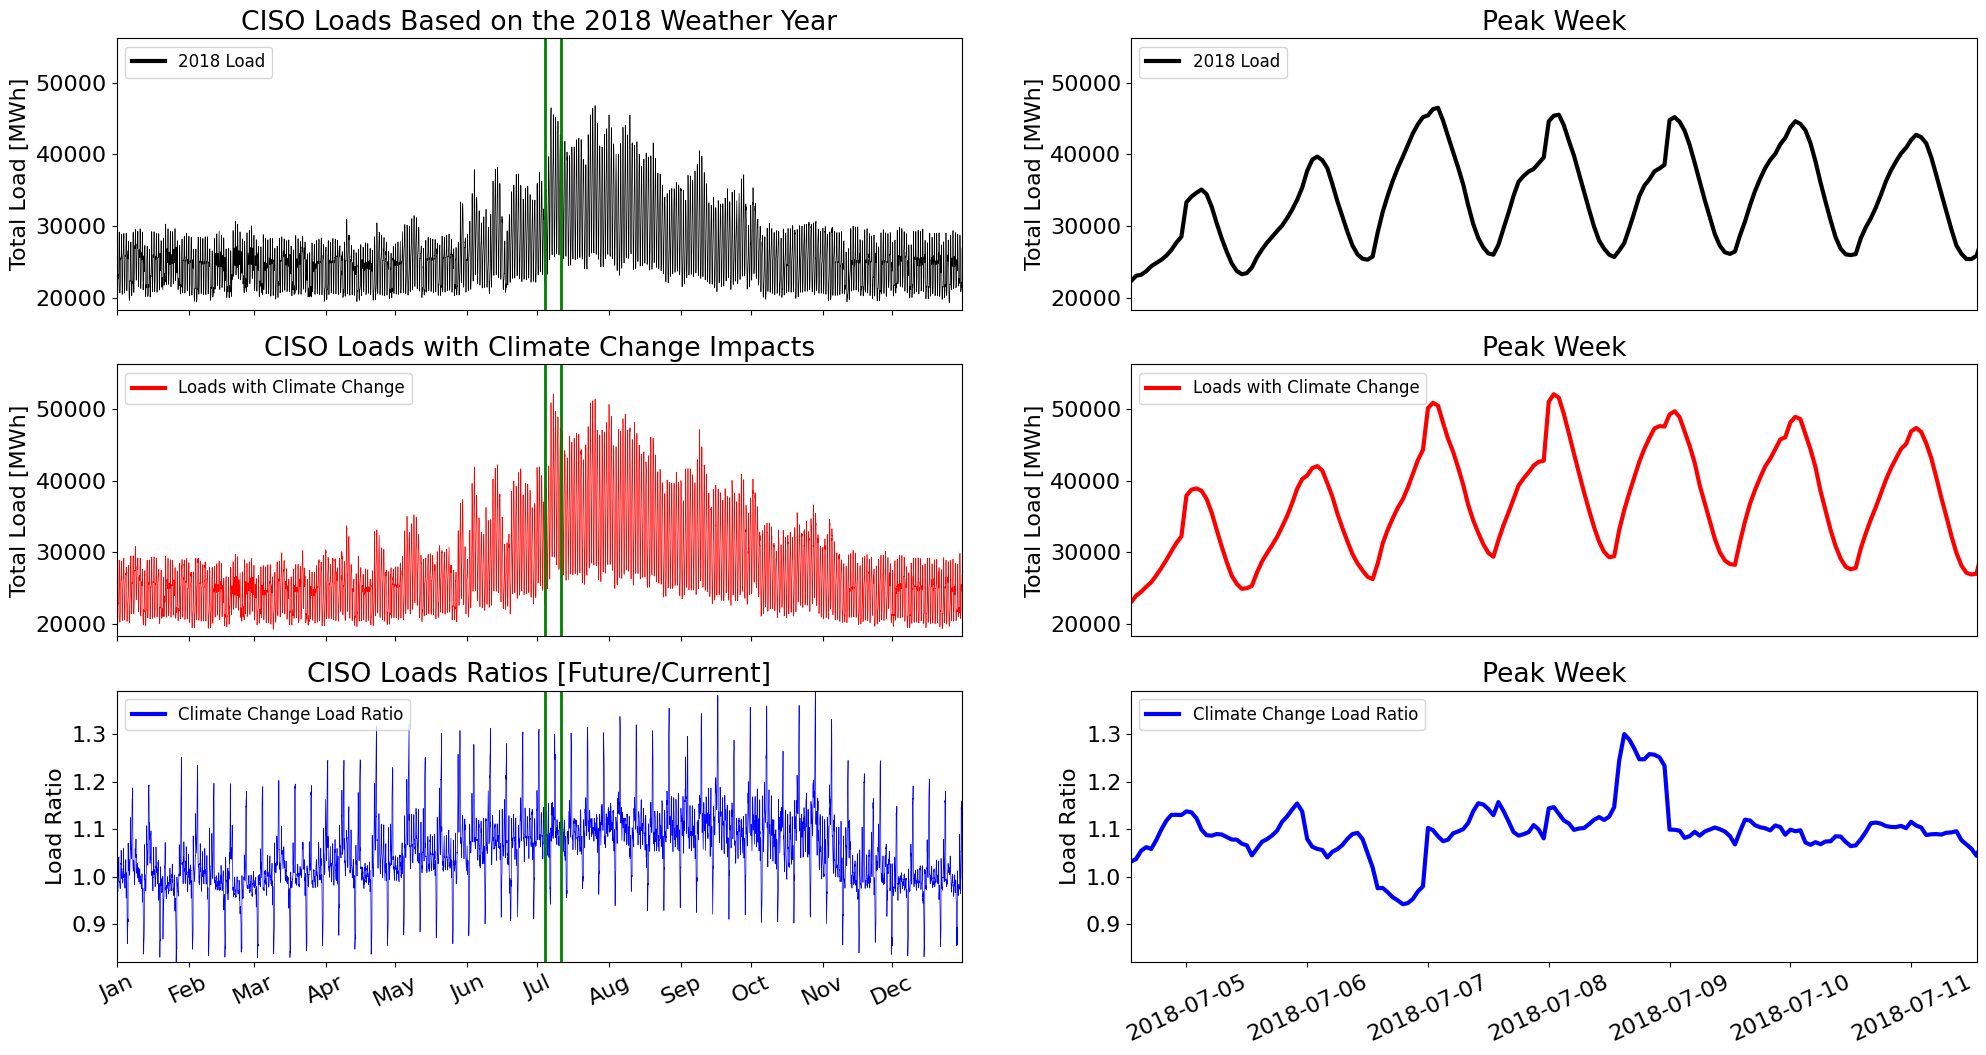

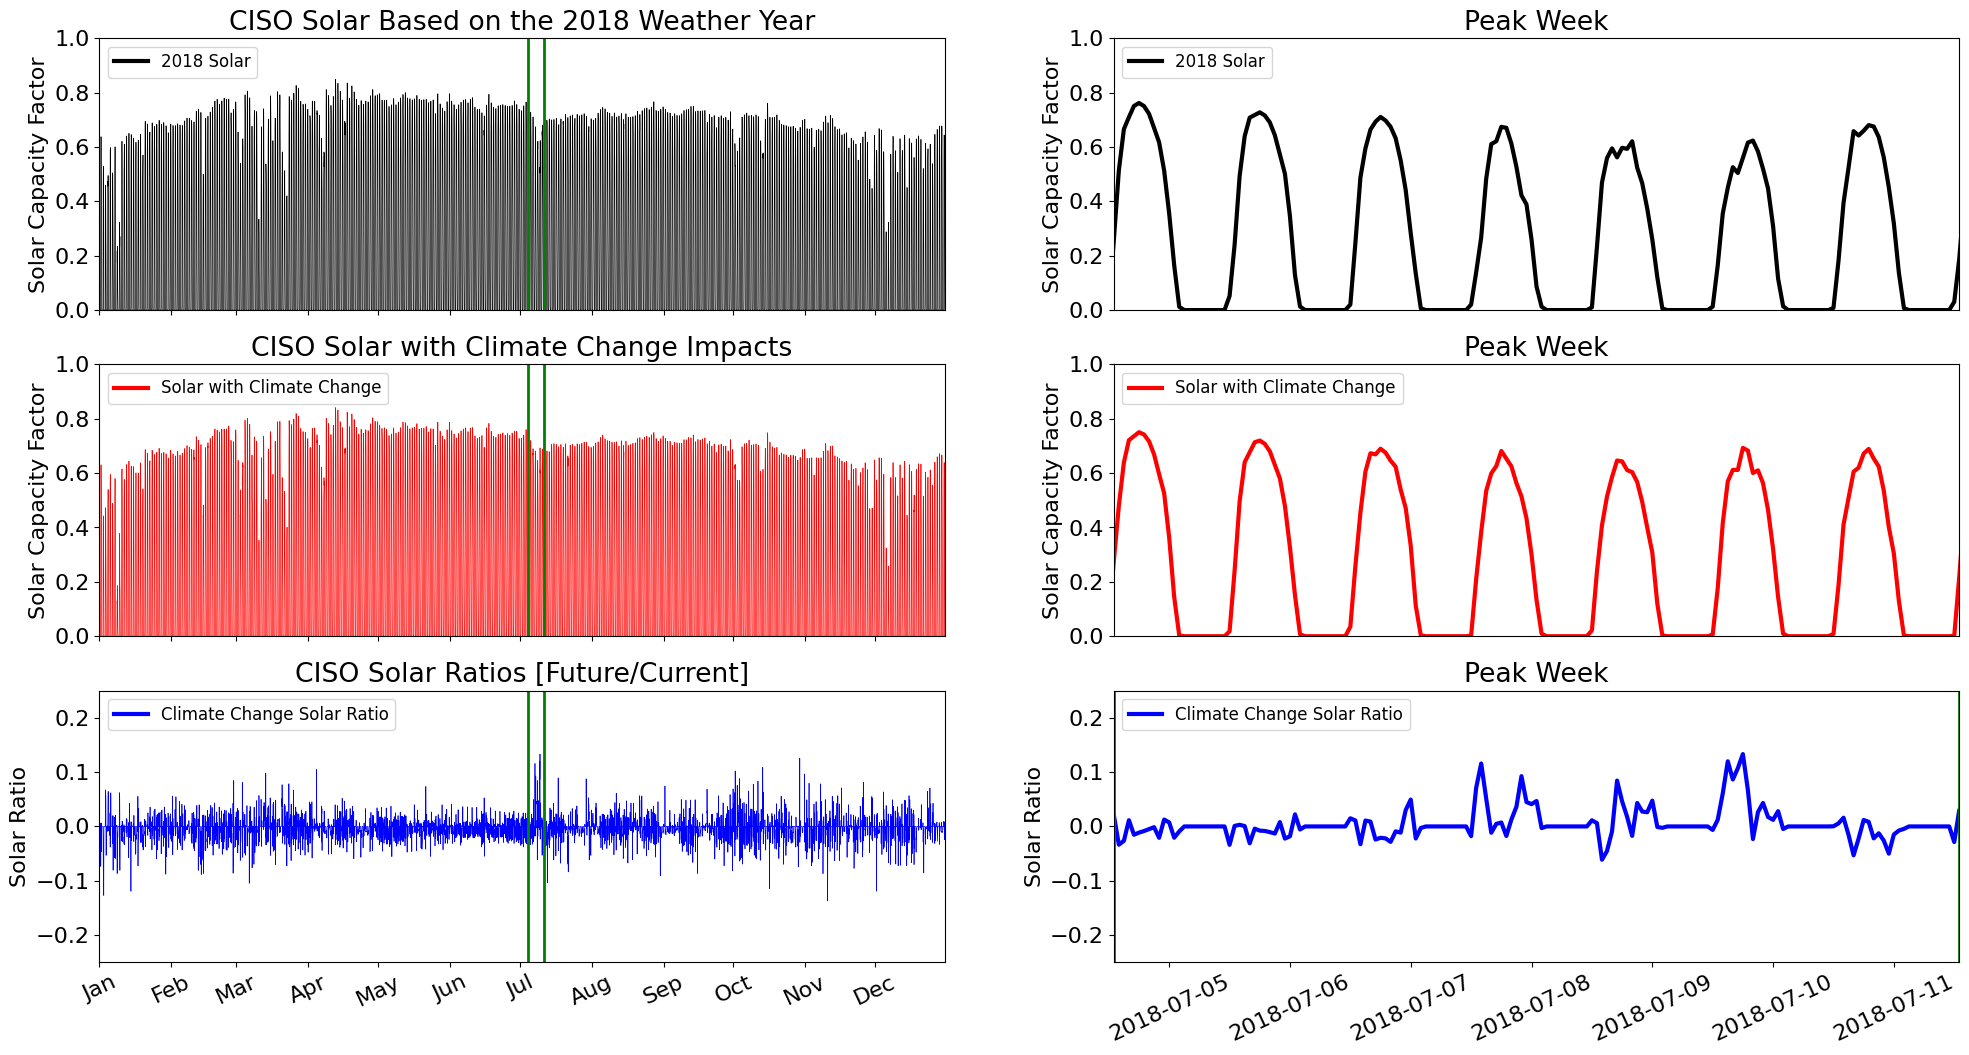

In [99]:
plot_df = plot_ba_time_series(ba_to_plot = 'CISO',
                              data_input_dir = data_input_dir, 
                              image_output_dir = image_output_dir, 
                              image_resolution = 100, 
                              save_images = True)

plot_df
